# Face Detection with Detectron2

All credits go to [@curiousily](https://www.curiousily.com/posts/face-detection-on-custom-dataset-with-detectron2-in-python/)..


## Setup

In [0]:
!pip install -q cython pyyaml==5.1
!pip install -q -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

And download, compile, and install the Detectron2 package:

In [0]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -q -e detectron2_repo

fatal: destination path 'detectron2_repo' already exists and is not an empty directory.



> Restart kernel now.

In [0]:
!pip install -q -U watermark

In [0]:
%reload_ext watermark
%watermark -v -p numpy,pandas,pycocotools,torch,torchvision,detectron2

CPython 3.6.9
IPython 5.5.0

numpy 1.18.3
pandas 1.0.3
pycocotools 2.0
torch 1.5.0+cu101
torchvision 0.6.0+cu101
detectron2 0.1.1


In [0]:
import torch, torchvision
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import glob

import os
import ntpath
import numpy as np
import cv2
import random
import itertools
import pandas as pd
from tqdm import tqdm
import urllib
import json
import PIL.Image as Image

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.structures import BoxMode

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Face Detection Data

- face dataset is from [Kaggle](https://www.kaggle.com/dataturks/face-detection-in-images)

> Faces in images marked with bounding boxes. Have around 500 images with around 1100 faces manually tagged via bounding box.


In [0]:
!gdown --id 1K79wJgmPTWamqb04Op2GxW0SW9oxw8KS

Downloading...
From: https://drive.google.com/uc?id=1K79wJgmPTWamqb04Op2GxW0SW9oxw8KS
To: /content/face_detection.json
100% 274k/274k [00:00<00:00, 39.6MB/s]


Let's load the file into a Pandas dataframe:

In [0]:
faces_df = pd.read_json('face_detection.json', lines=True)
faces_df.head()

content  ... extras
0  http://com.dataturks.a96-i23.open.s3.amazonaws...  ...    NaN
1  http://com.dataturks.a96-i23.open.s3.amazonaws...  ...    NaN
2  http://com.dataturks.a96-i23.open.s3.amazonaws...  ...    NaN
3  http://com.dataturks.a96-i23.open.s3.amazonaws...  ...    NaN
4  http://com.dataturks.a96-i23.open.s3.amazonaws...  ...    NaN

[5 rows x 3 columns]


Each line contains a single face annotation. Note that multiple lines might point to a single image (e.g. multiple faces per image).

### Data Preprocessing

- download actual data, normalize annotations

In [0]:
os.makedirs("faces", exist_ok=True)

dataset = []

for index, row in tqdm(faces_df.iterrows(), total=faces_df.shape[0]):
    img = urllib.request.urlopen(row["content"])
    img = Image.open(img)
    img = img.convert('RGB')

    image_name = f'face_{index}.jpeg'

    img.save(f'faces/{image_name}', "JPEG")
    
    annotations = row['annotation']
    for an in annotations:

      data = {}

      width = an['imageWidth']
      height = an['imageHeight']
      points = an['points']

      data['file_name'] = image_name
      data['width'] = width
      data['height'] = height

      data["x_min"] = int(round(points[0]["x"] * width))
      data["y_min"] = int(round(points[0]["y"] * height))
      data["x_max"] = int(round(points[1]["x"] * width))
      data["y_max"] = int(round(points[1]["y"] * height))

      data['class_name'] = 'face'

      dataset.append(data)
    

100%|██████████| 409/409 [03:33<00:00,  1.91it/s]


- dataframe is good



In [0]:
df = pd.DataFrame(dataset)
df.head()

file_name  width  height  x_min  y_min  x_max  y_max class_name
0  face_0.jpeg    650     333     56    102    112    151       face
1  face_0.jpeg    650     333    379     97    428    156       face
2  face_1.jpeg   1280     697    903    162    985    252       face
3  face_2.jpeg    460     240    216     12    279     80       face
4  face_2.jpeg    460     240    289      2    343     74       face

In [0]:
print(df.file_name.unique().shape[0], df.shape[0])

409 1132


In [0]:
df.to_csv('annotations.csv', header=True, index=None)

### Data Exploration

In [0]:
def annotate_image(annotations, resize=True):
  file_name = annotations.file_name.to_numpy()[0]
  img = cv2.cvtColor(cv2.imread(f'faces/{file_name}'), cv2.COLOR_BGR2RGB)

  for i, a in annotations.iterrows():    
    cv2.rectangle(img, (a.x_min, a.y_min), (a.x_max, a.y_max), (0, 255, 0), 2)

  if not resize:
    return img

  return cv2.resize(img, (384, 384), interpolation = cv2.INTER_AREA)

- let's look at some data

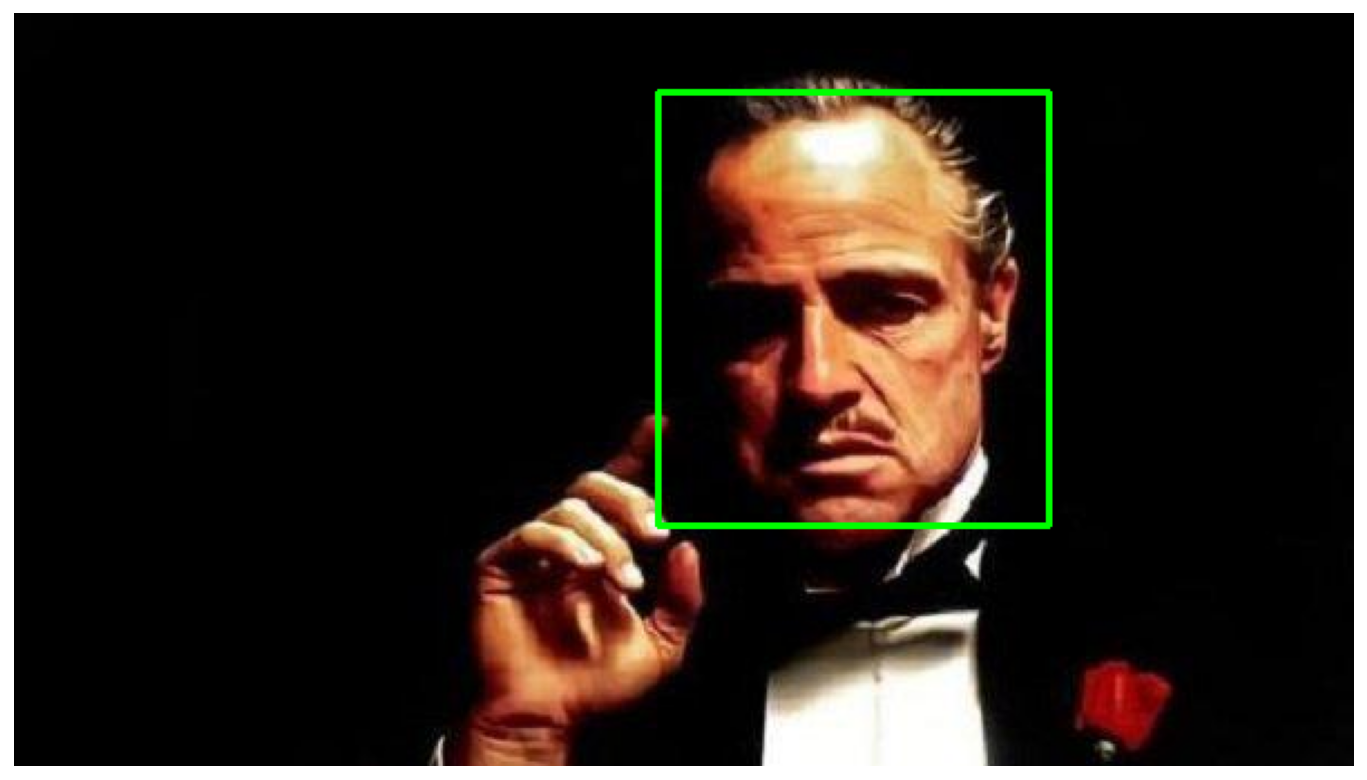

In [0]:
img_df = df[df.file_name == df.file_name.unique()[10]]
img = annotate_image(img_df, resize=False)

plt.imshow(img)
plt.axis('off');

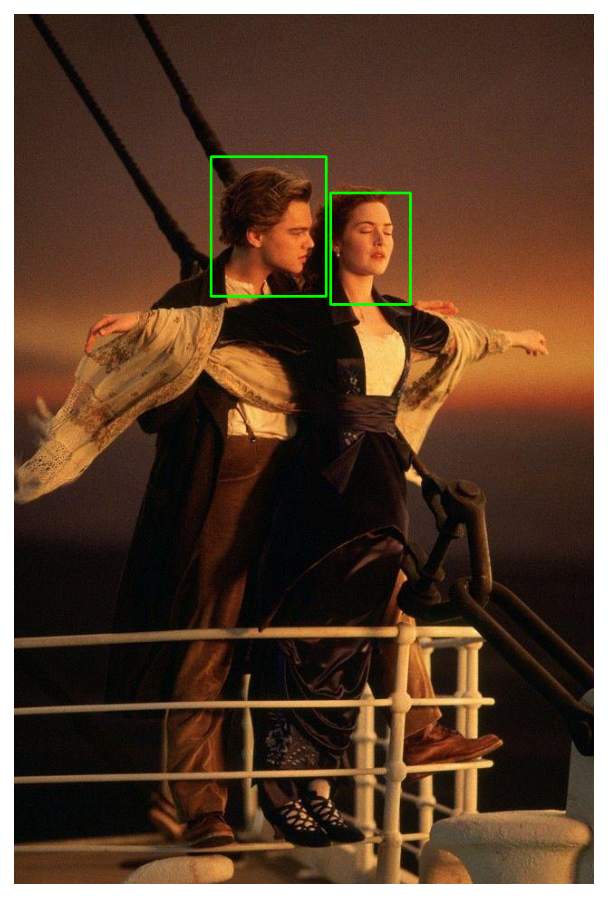

In [0]:
img_df = df[df.file_name == df.file_name.unique()[30]]
img = annotate_image(img_df, resize=False)

plt.imshow(img)
plt.axis('off');

- resize

In [0]:
sample_images = [annotate_image(df[df.file_name == f]) for f in df.file_name.unique()[:10]]
sample_images = torch.as_tensor(sample_images)

In [0]:
sample_images.shape

torch.Size([10, 384, 384, 3])

In [0]:
sample_images = sample_images.permute(0, 3, 1, 2)

In [0]:
sample_images.shape

torch.Size([10, 3, 384, 384])

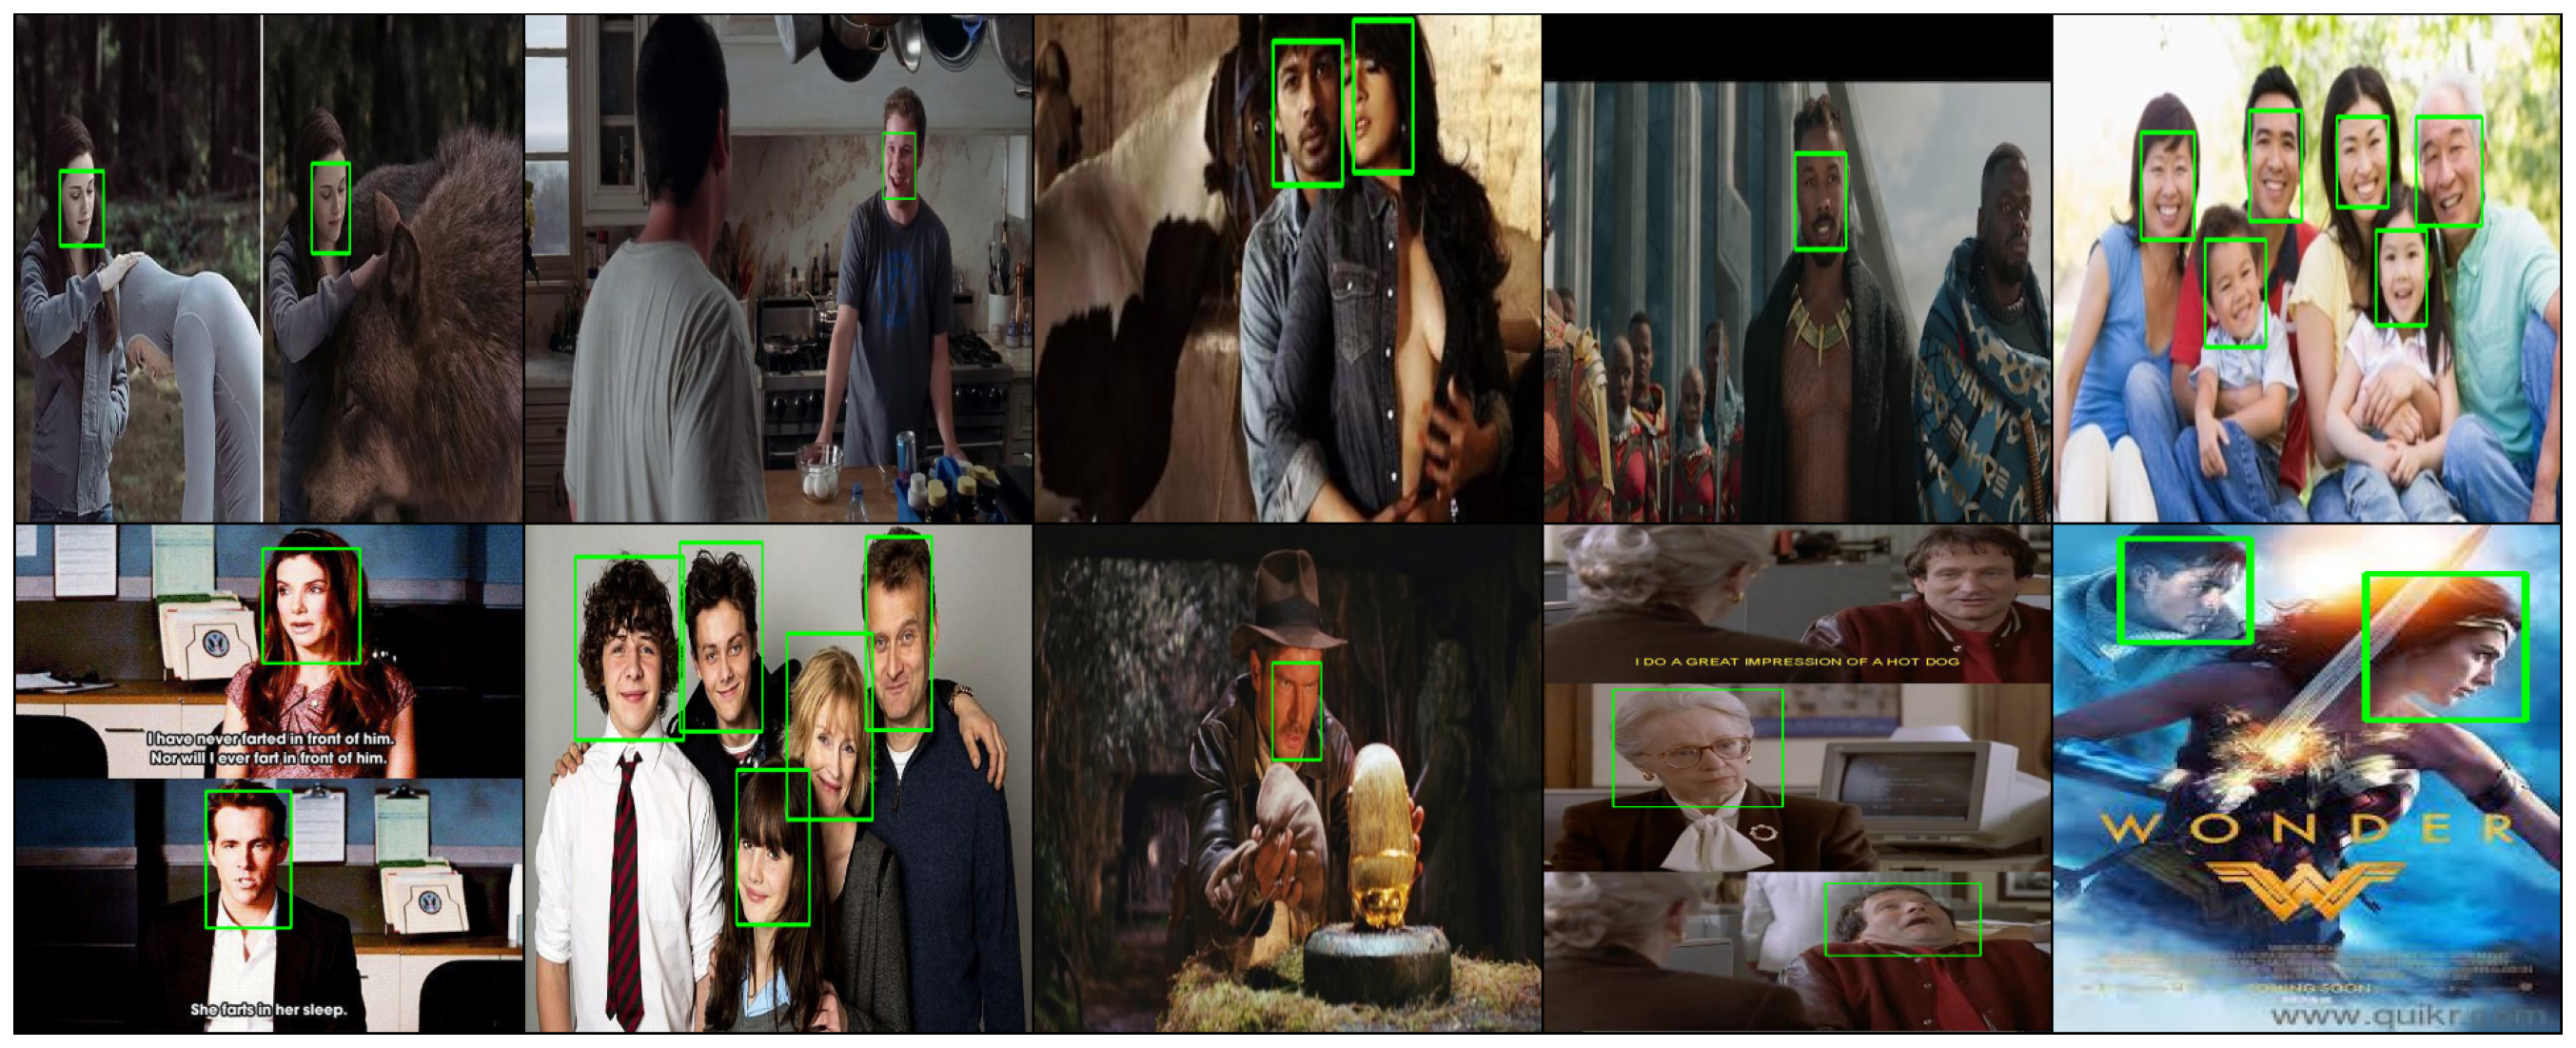

In [0]:
plt.figure(figsize=(24, 12))
grid_img = torchvision.utils.make_grid(sample_images, nrow=5)

plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off');

You can clearly see that some annotations are missing (column 4). That's real life data for you, sometimes you have to deal with it in some way.

## Face Detection with Detectron 2


In [0]:
df = pd.read_csv('annotations.csv')

IMAGES_PATH = f'faces'

unique_files = df.file_name.unique()

train_files = set(np.random.choice(unique_files, int(len(unique_files) * 0.95), replace=False))
train_df = df[df.file_name.isin(train_files)]
test_df = df[~df.file_name.isin(train_files)]

train_df.head()

file_name  width  height  x_min  y_min  x_max  y_max class_name
0  face_0.jpeg    650     333     56    102    112    151       face
1  face_0.jpeg    650     333    379     97    428    156       face
2  face_1.jpeg   1280     697    903    162    985    252       face
3  face_2.jpeg    460     240    216     12    279     80       face
4  face_2.jpeg    460     240    289      2    343     74       face

In [0]:
classes = df.class_name.unique().tolist()

Detectron2 needs data in dicts

In [0]:
def create_dataset_dicts(df, classes):
  dataset_dicts = []
  for image_id, img_name in enumerate(df.file_name.unique()):

    record = {}

    image_df = df[df.file_name == img_name]

    file_path = f'{IMAGES_PATH}/{img_name}'
    record["file_name"] = file_path
    record["image_id"] = image_id
    record["height"] = int(image_df.iloc[0].height)
    record["width"] = int(image_df.iloc[0].width)

    objs = []
    for _, row in image_df.iterrows():

      xmin = int(row.x_min)
      ymin = int(row.y_min)
      xmax = int(row.x_max)
      ymax = int(row.y_max)

      poly = [
          (xmin, ymin), (xmax, ymin), 
          (xmax, ymax), (xmin, ymax)
      ]
      poly = list(itertools.chain.from_iterable(poly))

      obj = {
        "bbox": [xmin, ymin, xmax, ymax],
        "bbox_mode": BoxMode.XYXY_ABS,
        "segmentation": [poly],
        "category_id": classes.index(row.class_name),
        "iscrowd": 0
      }
      objs.append(obj)

    record["annotations"] = objs
    dataset_dicts.append(record)
  return dataset_dicts

>We convert every annotation row to a single record with a list of annotations. You might also notice that we're building a polygon that is of the exact same shape as the bounding box. This is required for the image segmentation models in Detectron2.

> You'll have to register your dataset into the dataset and metadata catalogues:

In [0]:
for d in ["train", "val"]:
  DatasetCatalog.register("faces_" + d, lambda d=d: create_dataset_dicts(train_df if d == "train" else test_df, classes))
  MetadataCatalog.get("faces_" + d).set(thing_classes=classes)

statement_metadata = MetadataCatalog.get("faces_train")

Let's include evaluator for the test set too


In [0]:
class CocoTrainer(DefaultTrainer):
  
  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

The evaluation results will be stored in the `coco_eval` folder if no folder is provided.

Fine-tuning a Detectron2 model is nothing like writing PyTorch code. We'll load a configuration file, change a few values, and start the training process. But hey, it really helps if you know what you're doing 😂

For this tutorial, we'll use the Mask R-CNN X101-FPN model. It is pre-trained on the [COCO dataset](http://cocodataset.org/#home) and achieves very good performance. The downside is that it is slow to train.

Let's load the config file and the pre-trained model weights:

In [0]:
cfg = get_cfg()

cfg.merge_from_file(
  model_zoo.get_config_file(
    "COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"
  )
)

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
  "COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"
)

Specify the datasets (we registered those) we'll use for training and evaluation:

In [0]:
cfg.DATASETS.TRAIN = ("faces_train",)
cfg.DATASETS.TEST = ("faces_val",)
cfg.DATALOADER.NUM_WORKERS = 4

And for the optimizer, we'll do a bit of magic to converge to something nice:

In [0]:
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 1500
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05

Except for the standard stuff (batch size, max number of iterations, and learning rate) we have a couple of interesting params:

- `WARMUP_ITERS` - the learning rate starts from 0 and goes to the preset one for this number of iterations
- `STEPS` - the checkpoints (number of iterations) at which the learning rate will be reduced by `GAMMA`

Finally, we'll specify the number of classes and the period at which we'll evaluate on the test set:

In [0]:
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(classes)

cfg.TEST.EVAL_PERIOD = 500

Time to train, using our custom trainer:

In [0]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

trainer = CocoTrainer(cfg) 
trainer.resume_or_load(resume=False)
#trainer.train() UNCOMMENT IF YOU WANT TO TRAIN HERE

[04/30 03:15:11 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

## Evaluation

Let's use pre-trained model though:

In [0]:
!gdown --id 18Ev2bpdKsBaDufhVKf0cT6RmM3FjW3nL

Downloading...
From: https://drive.google.com/uc?id=18Ev2bpdKsBaDufhVKf0cT6RmM3FjW3nL
To: /content/face_detector.pth
856MB [00:03, 219MB/s]
mv: cannot move 'face_detector.pth' to 'output/model_final.pth': No such file or directory


Let's say 85% is good enough


In [0]:
cfg.MODEL.WEIGHTS = "/content/face_detector.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)

and evaluate

In [0]:
evaluator = COCOEvaluator("faces_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "faces_val")
inference_on_dataset(trainer.model, val_loader, evaluator)

Does it work?

In [0]:
os.makedirs("annotated_results", exist_ok=True)

test_image_paths = test_df.file_name.unique()

In [0]:
test_image_paths

array(['face_20.jpeg', 'face_71.jpeg', 'face_87.jpeg', 'face_99.jpeg',
       'face_102.jpeg', 'face_106.jpeg', 'face_121.jpeg', 'face_130.jpeg',
       'face_149.jpeg', 'face_151.jpeg', 'face_188.jpeg', 'face_214.jpeg',
       'face_257.jpeg', 'face_270.jpeg', 'face_308.jpeg', 'face_330.jpeg',
       'face_343.jpeg', 'face_348.jpeg', 'face_359.jpeg', 'face_372.jpeg',
       'face_408.jpeg'], dtype=object)

In [0]:
for clothing_image in test_image_paths:
  file_path = f'{IMAGES_PATH}/{clothing_image}'
  im = cv2.imread(file_path)
  outputs = predictor(im)
  v = Visualizer(
    im[:, :, ::-1],
    metadata=statement_metadata, 
    scale=1., 
    instance_mode=ColorMode.IMAGE
  )
  instances = outputs["instances"].to("cpu")
  instances.remove('pred_masks')
  v = v.draw_instance_predictions(instances)
  result = v.get_image()[:, :, ::-1]
  file_name = ntpath.basename(clothing_image)
  write_res = cv2.imwrite(f'annotated_results/{file_name}', result)

Let's have a look:

In [0]:
annotated_images = [f'annotated_results/{f}' for f in test_df.file_name.unique()]

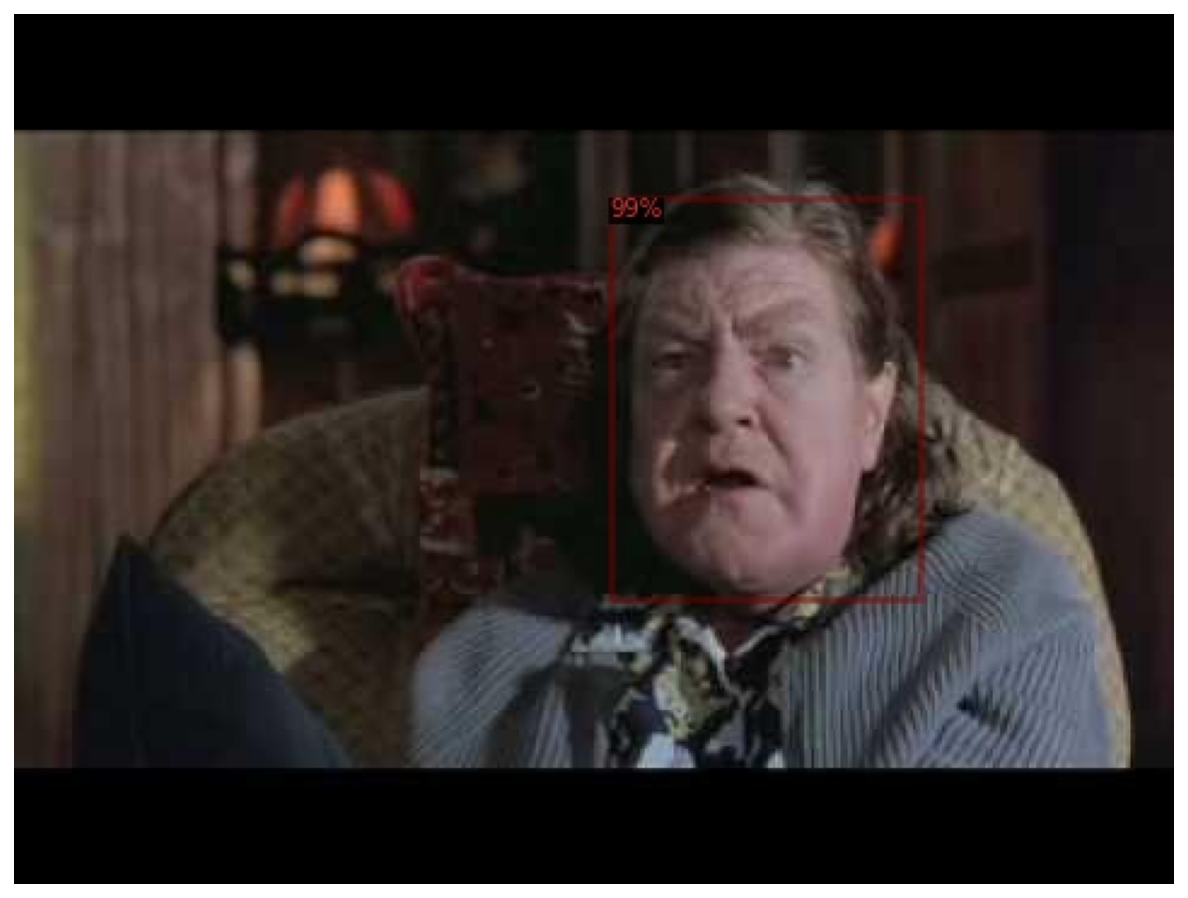

In [0]:
img = cv2.cvtColor(cv2.imread(annotated_images[0]), cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis('off');

## Task — annotate a picture of yourself

1. Take a photo of yourself (and other people possibly)
2. Upload it to this environment
3. Use pre-trained model to annotate it
4. Display it


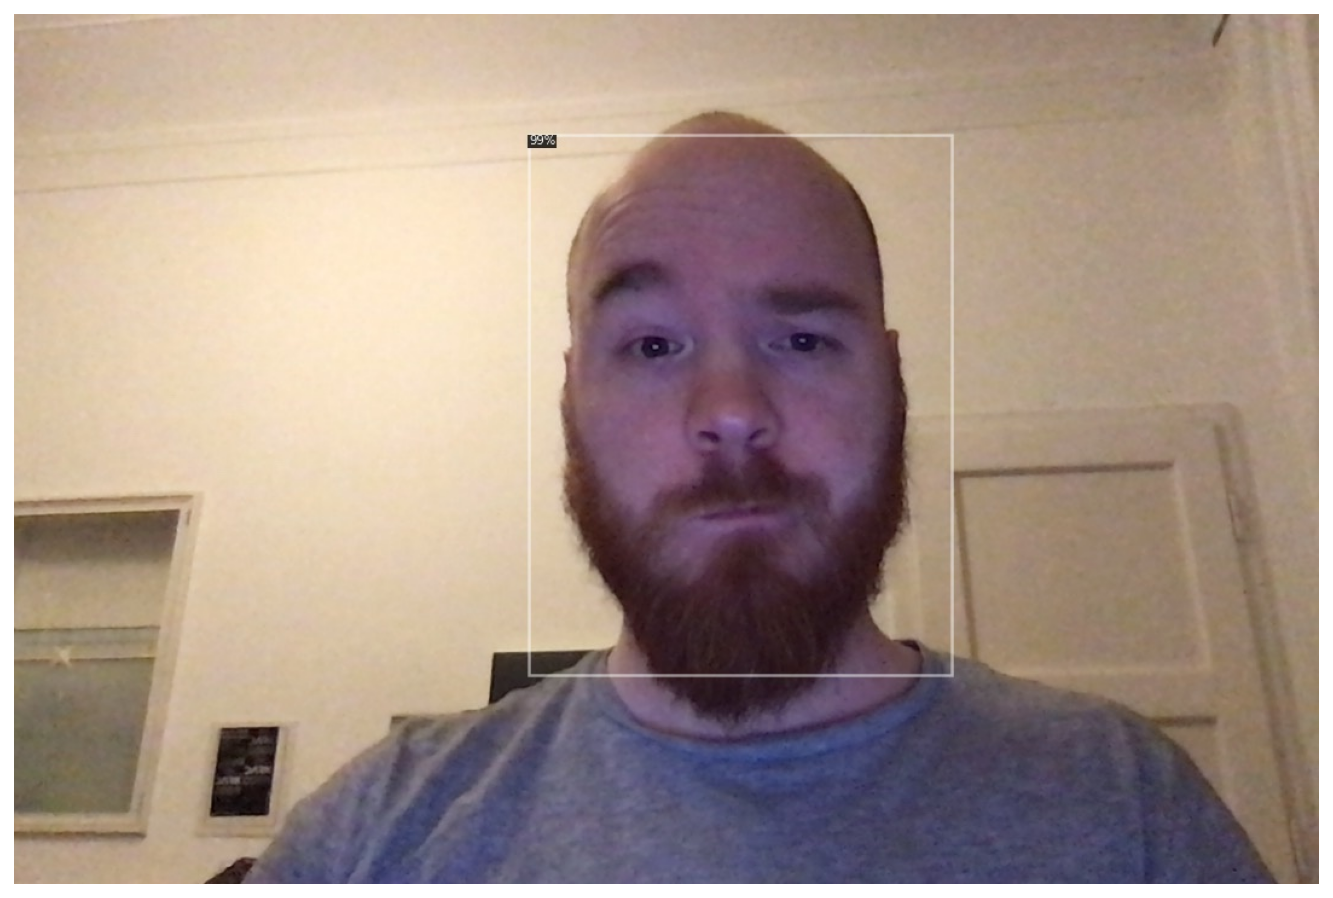

In [0]:
img = ###